In [ ]:
import numpy as np

def entropia (labels):
   _, counts = np.unique(labels, return_counts=True)
    probabilities = counts / counts.sum()
    return -np.sum(probabilities * np.log2(probabilities))

# Exemplo:
labels = np.array(['A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B'])
print("Entropia:", entropy(labels))  # Saída ≈ 0.97


IndentationError: unexpected indent (<ipython-input-1-af561ba7f504>, line 5)

somatorio de kahn + algoritimo de regressao linear

MSE com Regressão Linear padrão: 0.0114277513
MSE com Regressão Linear usando soma de Kahan: 0.0114277513


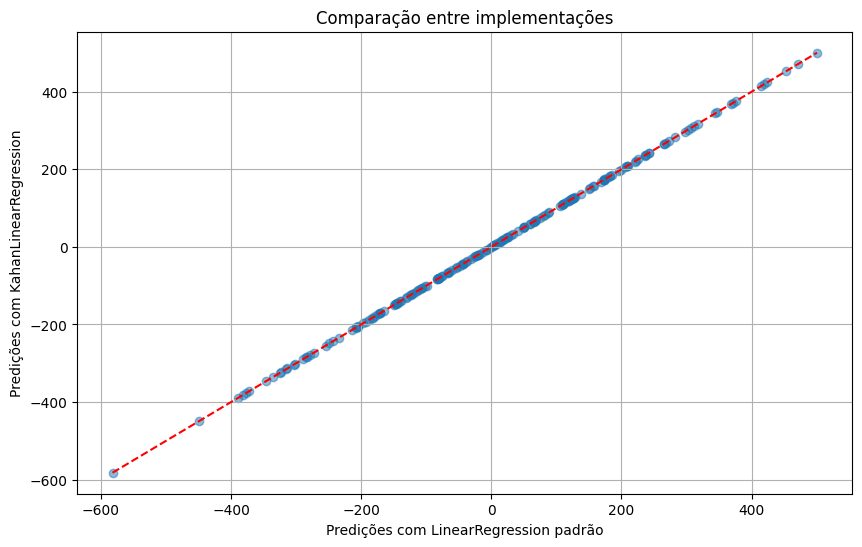

In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

def kahan_sum(values):
    """
    Implementa o algoritmo de soma de Kahan para reduzir erros de arredondamento.
    """
    s = 0.0  # Soma
    c = 0.0  # Termo de correção

    for v in values:
        y = v - c  # O valor a ser adicionado corrigido
        t = s + y  # Próxima soma
        c = (t - s) - y  # Novo termo de correção
        s = t  # Atualiza soma

    return s

class KahanLinearRegression(BaseEstimator, RegressorMixin):
    """
    Regressão Linear usando o somatório de Kahan para cálculos mais precisos.
    """

    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept

    def fit(self, X, y):
        X, y = check_X_y(X, y)

        if self.fit_intercept:
            X = np.column_stack([np.ones(X.shape[0]), X])

        # Calculando (X^T * X)^-1 * X^T * y com somas de Kahan
        XtX = np.zeros((X.shape[1], X.shape[1]))

        # Calcular X^T * X com somatório de Kahan
        for i in range(X.shape[1]):
            for j in range(X.shape[1]):
                products = X[:, i] * X[:, j]
                XtX[i, j] = kahan_sum(products)

        Xty = np.zeros(X.shape[1])

        # Calcular X^T * y com somatório de Kahan
        for i in range(X.shape[1]):
            products = X[:, i] * y
            Xty[i] = kahan_sum(products)

        # Resolver o sistema de equações normais
        self.coef_ = np.linalg.solve(XtX, Xty)

        # Separar o intercepto dos coeficientes, se necessário
        if self.fit_intercept:
            self.intercept_ = self.coef_[0]
            self.coef_ = self.coef_[1:]
        else:
            self.intercept_ = 0.0

        return self

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)

        y_pred = np.zeros(X.shape[0])

        # Predição com somatório de Kahan
        for i in range(X.shape[0]):
            products = self.coef_ * X[i]
            y_pred[i] = kahan_sum(products) + self.intercept_

        return y_pred

# Exemplo de uso
if __name__ == "__main__":
    from sklearn.datasets import make_regression
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_squared_error
    from sklearn.linear_model import LinearRegression
    import matplotlib.pyplot as plt

    # Criar dados sintéticos
    X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=42)

    # Dividir em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Treinar modelo com soma de Kahan
    kahan_model = KahanLinearRegression()
    kahan_model.fit(X_train, y_train)
    kahan_pred = kahan_model.predict(X_test)
    kahan_mse = mean_squared_error(y_test, kahan_pred)

    # Comparar com a implementação padrão do sklearn
    sklearn_model = LinearRegression()
    sklearn_model.fit(X_train, y_train)
    sklearn_pred = sklearn_model.predict(X_test)
    sklearn_mse = mean_squared_error(y_test, sklearn_pred)

    print(f"MSE com Regressão Linear padrão: {sklearn_mse:.10f}")
    print(f"MSE com Regressão Linear usando soma de Kahan: {kahan_mse:.10f}")

    # Visualizar diferenças nas predições
    plt.figure(figsize=(10, 6))
    plt.scatter(sklearn_pred, kahan_pred, alpha=0.5)
    plt.plot([min(sklearn_pred), max(sklearn_pred)], [min(sklearn_pred), max(sklearn_pred)], 'r--')
    plt.xlabel('Predições com LinearRegression padrão')
    plt.ylabel('Predições com KahanLinearRegression')
    plt.title('Comparação entre implementações')
    plt.grid(True)
    plt.show()

arvore de regresao

Dimensões do conjunto de treino: (105, 4)
Dimensões do conjunto de teste: (45, 4)
Acurácia: 1.0000

Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



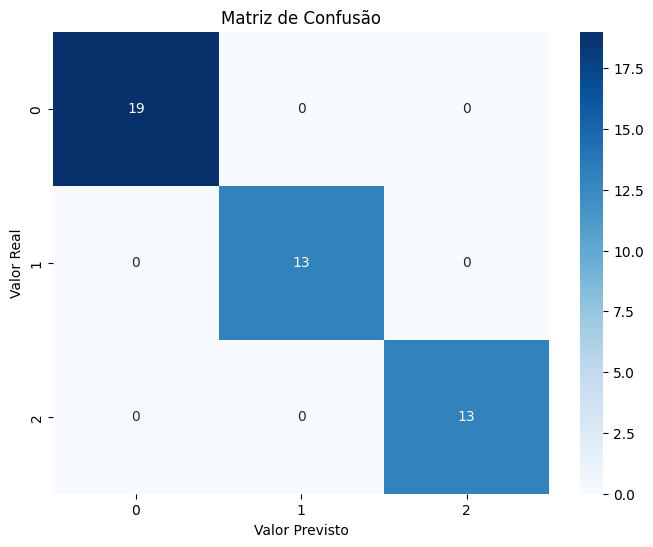

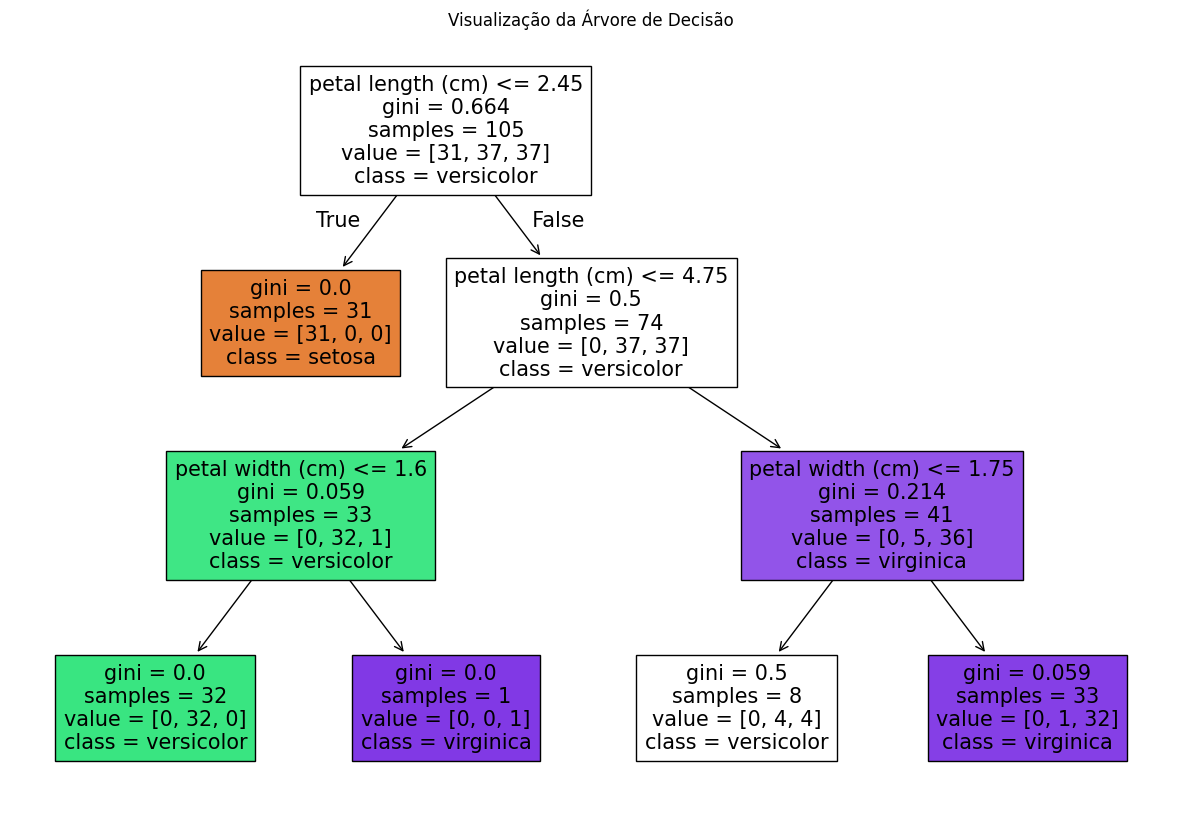

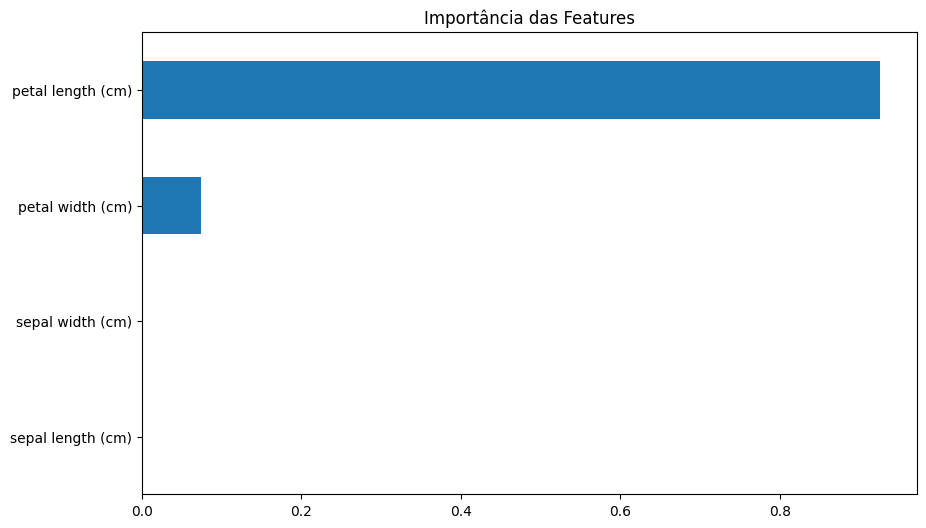

In [ ]:
#modelo de arvore de decisao para classificacao

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import tree

# Função para carregar e preparar os dados
def carregar_dados(arquivo_csv):
    # Carregar o dataset
    dados = pd.read_csv(arquivo_csv)
    print("Informações do dataset:")
    print(dados.info())
    print("\nPrimeiras linhas do dataset:")
    print(dados.head())
    return dados

# Função para dividir os dados em conjunto de treino e teste
def dividir_dados(X, y, test_size=0.3, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    print(f"Dimensões do conjunto de treino: {X_train.shape}")
    print(f"Dimensões do conjunto de teste: {X_test.shape}")
    return X_train, X_test, y_train, y_test

# Função para treinar e avaliar o modelo
def treinar_arvore_decisao(X_train, X_test, y_train, y_test, max_depth=None):
    # Criar e treinar o modelo
    modelo = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    modelo.fit(X_train, y_train)

    # Fazer previsões
    y_pred = modelo.predict(X_test)

    # Avaliar o modelo
    acuracia = accuracy_score(y_test, y_pred)
    print(f"Acurácia: {acuracia:.4f}")
    print("\nRelatório de Classificação:")
    print(classification_report(y_test, y_pred))

    # Matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Matriz de Confusão')
    plt.ylabel('Valor Real')
    plt.xlabel('Valor Previsto')
    plt.show()

    return modelo

# Função para visualizar a árvore de decisão
def visualizar_arvore(modelo, feature_names, class_names):
    plt.figure(figsize=(15, 10))
    tree.plot_tree(modelo, feature_names=feature_names, class_names=class_names, filled=True)
    plt.title("Visualização da Árvore de Decisão")
    plt.show()

# Exemplo de uso
if __name__ == "__main__":
    # Substitua 'dataset.csv' pelo caminho do seu arquivo CSV
    # dados = carregar_dados('dataset.csv')

    # Exemplo com o dataset Iris (já vem com o scikit-learn)
    from sklearn.datasets import load_iris
    iris = load_iris()
    X = pd.DataFrame(iris.data, columns=iris.feature_names)
    y = iris.target

    # Dividir os dados
    X_train, X_test, y_train, y_test = dividir_dados(X, y)

    # Treinar o modelo
    modelo = treinar_arvore_decisao(X_train, X_test, y_train, y_test, max_depth=3)

    # Visualizar a árvore
    visualizar_arvore(modelo, feature_names=iris.feature_names, class_names=iris.target_names)

    # Importância das features
    importancia = pd.Series(modelo.feature_importances_, index=iris.feature_names)
    plt.figure(figsize=(10, 6))
    importancia.sort_values().plot(kind='barh')
    plt.title('Importância das Features')
    plt.show()






